In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Для ускорения apply функций данные немаленькие
from pandarallel import pandarallel

pandarallel.initialize()

sns.set()

%config InlineBackend.figure_format = 'svg'

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["image.cmap"] = "viridis"

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Загрузка данных

In [2]:
data = pd.read_parquet("../data/transaction_fraud_data.parquet")
exchange = pd.read_parquet("../data/historical_currency_exchange.parquet")

In [3]:
data = pd.concat((data, pd.json_normalize(data["last_hour_activity"])), axis=1).drop(
    columns="last_hour_activity"
)

In [4]:
exchange["date"] = pd.to_datetime(exchange["date"]).dt.date
data["date"] = data["timestamp"].dt.date

# EDA

In [5]:
data.head()

transaction_id customer_id       card_number                  timestamp  \
0    TX_a0ad2a2a  CUST_72886  6646734767813109 2024-09-30 00:00:01.034820   
1    TX_3599c101  CUST_70474   376800864692727 2024-09-30 00:00:01.764464   
2    TX_a9461c6d  CUST_10715  5251909460951913 2024-09-30 00:00:02.273762   
3    TX_7be21fc4  CUST_16193   376079286931183 2024-09-30 00:00:02.297466   
4    TX_150f490b  CUST_87572  6172948052178810 2024-09-30 00:00:02.544063   

  vendor_category vendor_type          vendor     amount currency    country  \
0      Restaurant   fast_food       Taco Bell     294.87      GBP         UK   
1   Entertainment      gaming           Steam    3368.97      BRL     Brazil   
2         Grocery    physical     Whole Foods  102582.38      JPY      Japan   
3             Gas       major           Exxon     630.60      AUD  Australia   
4      Healthcare     medical  Medical Center  724949.27      NGN    Nigeria   

   ... is_outside_home_country is_high_risk_vendor is_weekend  is_fraud  \
0  ...                   False               False      False     False   
1  ...                    True                True      False      True   
2  ...                   False               False      False     False   
3  ...                   False               False      False     False   
4  ...                    True               False      False      True   

  num_transactions  total_amount unique_merchants unique_countries  \
0             1197  3.349856e+07              105               12   
1              509  2.011476e+07              100               12   
2              332  3.916385e+07               97               12   
3              764  2.201260e+07              105               12   
4              218  4.827636e+06               88               12   

   max_single_amount        date  
0       1.925481e+06  2024-09-30  
1       5.149117e+06  2024-09-30  
2       1.852242e+06  2024-09-30  
3       2.055798e+06  2024-09-30  
4       1.157231e+06  2024-09-30  

[5 rows x 28 columns]

In [6]:
exchange.head()

date       AUD       BRL       CAD       EUR       GBP         JPY  \
0  2024-09-30  1.443654  5.434649  1.351196  0.895591  0.747153  142.573268   
1  2024-10-01  1.442917  5.444170  1.352168  0.897557  0.746956  143.831429   
2  2024-10-02  1.449505  5.425444  1.348063  0.903056  0.752241  143.806861   
3  2024-10-03  1.456279  5.442044  1.351451  0.906018  0.754584  146.916773   
4  2024-10-04  1.460930  5.477788  1.355260  0.906452  0.761891  146.592323   

         MXN          NGN        RUB       SGD  USD  
0  19.694724  1668.736400  94.133735  1.280156    1  
1  19.667561  1670.694524  92.898519  1.284352    1  
2  19.606748  1669.653006  94.583198  1.286983    1  
3  19.457701  1670.097873  95.655442  1.294391    1  
4  19.363467  1649.763738  94.755337  1.296800    1

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7483766 entries, 0 to 7483765
Data columns (total 28 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   transaction_id           object        
 1   customer_id              object        
 2   card_number              int64         
 3   timestamp                datetime64[us]
 4   vendor_category          object        
 5   vendor_type              object        
 6   vendor                   object        
 7   amount                   float64       
 8   currency                 object        
 9   country                  object        
 10  city                     object        
 11  city_size                object        
 12  card_type                object        
 13  is_card_present          bool          
 14  device                   object        
 15  channel                  object        
 16  device_fingerprint       object        
 17  ip_address               ob

In [8]:
exchange.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    31 non-null     object 
 1   AUD     31 non-null     float64
 2   BRL     31 non-null     float64
 3   CAD     31 non-null     float64
 4   EUR     31 non-null     float64
 5   GBP     31 non-null     float64
 6   JPY     31 non-null     float64
 7   MXN     31 non-null     float64
 8   NGN     31 non-null     float64
 9   RUB     31 non-null     float64
 10  SGD     31 non-null     float64
 11  USD     31 non-null     int64  
dtypes: float64(10), int64(1), object(1)
memory usage: 3.0+ KB


In [9]:
data = data.merge(exchange, how="left", on="date")

In [10]:
data.isna().sum()

transaction_id             0
customer_id                0
card_number                0
timestamp                  0
vendor_category            0
vendor_type                0
vendor                     0
amount                     0
currency                   0
country                    0
city                       0
city_size                  0
card_type                  0
is_card_present            0
device                     0
channel                    0
device_fingerprint         0
ip_address                 0
is_outside_home_country    0
is_high_risk_vendor        0
is_weekend                 0
is_fraud                   0
num_transactions           0
total_amount               0
unique_merchants           0
unique_countries           0
max_single_amount          0
date                       0
AUD                        0
BRL                        0
CAD                        0
EUR                        0
GBP                        0
JPY                        0
MXN           

In [11]:
data["is_fraud"].value_counts(normalize=True)

is_fraud
False    0.800272
True     0.199728
Name: proportion, dtype: float64

Сразу конвертируем amount в USD

In [12]:
data["usd_amount"] = data.parallel_apply(
    lambda x: x["amount"] / x[x["currency"]], axis=1
)
data["usd_total_amount"] = data.parallel_apply(
    lambda x: x["total_amount"] / x[x["currency"]], axis=1
)
data["usd_max_single_amount"] = data.parallel_apply(
    lambda x: x["max_single_amount"] / x[x["currency"]], axis=1
)

## Анализ объема транзакций

Посмотрим распределение usd_amount для is_fraud

Данных слишком много, засемплируем только часть для отрисовки

In [13]:
sns.boxplot(data=data.sample(frac=0.1, random_state=22), y="usd_amount", x="is_fraud");

В целом мы получили очевидный вывод, что сумма мошеннических транзакций зачастую является выбросами и большеми объемами

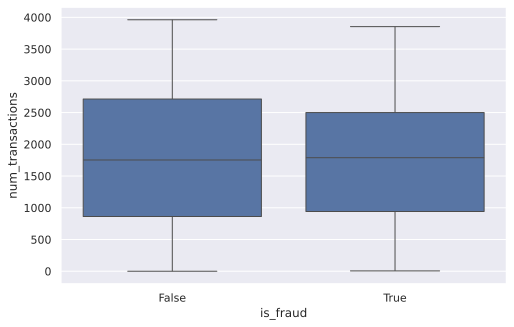

In [14]:
sns.boxplot(data=data.drop_duplicates("num_transactions"), y="num_transactions", x="is_fraud");

Количество транзакций за последний час малоинформативно, вероятнее всего, потому что мошенничество происходит одной большой транзакцией

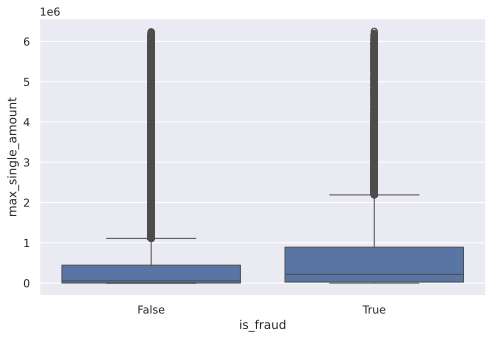

In [15]:
sns.boxplot(data=data.drop_duplicates("max_single_amount"), y="max_single_amount", x="is_fraud");

Действительно, дело в одной большой транзакции

## Анализ времени транзакций

In [16]:
data["hour"] = data["timestamp"].dt.hour

In [17]:
fraud_hours = data.groupby("hour")["is_fraud"].sum()
(fraud_hours * 100.0 / fraud_hours.sum()).sort_values().iloc[-5:]

hour
11     2.800326
3     11.080410
1     11.105699
2     11.107439
4     11.133731
Name: is_fraud, dtype: float64

Получаем, что более 44% всех мошеннических транзакций были произведены с часа ночи до пяти утра

In [18]:
fraud_weekends = data.groupby("is_weekend")["is_fraud"].sum()
(fraud_weekends * 100.0 / fraud_weekends.sum())

is_weekend
False    74.21308
True     25.78692
Name: is_fraud, dtype: float64

Была ли транзакция в выходной день мало что говорит

## Анализ транзакций

Топ стран с наибольшим количеством мошеннических операций

In [19]:
fraud_countries = data.groupby("country")["is_fraud"].sum()
(fraud_countries * 100.0 / fraud_countries.sum()).sort_values().iloc[-5:]

country
Australia     2.519002
Nigeria      19.976999
Brazil       19.978939
Mexico       19.993122
Russia       20.032193
Name: is_fraud, dtype: float64

Интересно, что почти 80% мошеннических транзакций произведены в 33% представленных стран

In [20]:
fraud_vendors = data.groupby("vendor_category")["is_fraud"].sum()
(fraud_vendors * 100.0 / fraud_vendors.sum()).sort_values()

vendor_category
Education        12.457392
Retail           12.484822
Healthcare       12.495258
Gas              12.499272
Entertainment    12.503353
Restaurant       12.507435
Grocery          12.509843
Travel           12.542625
Name: is_fraud, dtype: float64

Среди вендоров особых отличий нет

In [21]:
customer_data = data.groupby("customer_id").agg({"timestamp": lambda x: x.diff().mean().seconds, "is_fraud": lambda x: x.sum() / x.shape[0]})
customer_data.corr()

timestamp  is_fraud
timestamp    1.00000  -0.24441
is_fraud    -0.24441   1.00000

Интересная зависимость скорости проведения транзакций и количества мошеннических транзакций для клиента

Слабая, но все же корреляция у нас получилась. Чем выше скорость транзакций пользователя, тем ниже доля мошеннических транзакций

Интуитивно кажется, что должно быть иначе

In [22]:
fraud_risk = data.groupby("is_high_risk_vendor")["is_fraud"].sum()
(fraud_risk * 100.0 / fraud_risk.sum()).sort_values()

is_high_risk_vendor
True     25.045979
False    74.954021
Name: is_fraud, dtype: float64

In [23]:
fraud_risk = data.groupby("is_outside_home_country")["is_fraud"].sum()
(fraud_risk * 100.0 / fraud_risk.sum()).sort_values()

is_outside_home_country
False     8.452626
True     91.547374
Name: is_fraud, dtype: float64

In [24]:
fraud_devuce = data.groupby("device")["is_fraud"].sum()
(fraud_devuce * 100.0 / fraud_devuce.sum()).sort_values()

device
Edge                9.291713
Chrome              9.372129
iOS App             9.386781
Android App         9.422774
Safari              9.458567
Firefox             9.511554
NFC Payment        14.485599
Magnetic Stripe    14.531427
Chip Reader        14.539455
Name: is_fraud, dtype: float64

Очевидно, что этот признак должен быть одним из самых полезных, но признак is_high_risk_vendor лишь ввод в заблуждение.

Непонятно как он составлялся, хотя ранее мы видели, что зависимости от вендора нет

Также интересны результаты по девайсу транзакций, интуитивно кажется, что мошеннических транзакций через интернет должно быть больше остальных